In [1]:
from TSCFLP_instance import TSCFLPinstance
from TSCFLP_greedy_decoder import greedy_decoder
import torch
import torch.nn as nn
import numpy as np

In [2]:
class Generator(nn.Module):
    def __init__(self,I,J,population):
        super().__init__()
        self.population = population
        self.rede = nn.Sequential(
            nn.Linear(I+J,200),
            nn.ReLU(),
            nn.Linear(200,300),
            nn.ReLU(),
            nn.Linear(300,300),
            nn.ReLU(),
            nn.Linear(300,(I+J)*population),
            nn.Sigmoid()
        )
    def forward(self,ruido):
        x = self.rede(ruido)
        x = torch.reshape(x,(self.population,150))
        return x
        
        

In [3]:
class evaluate_population(nn.Module):
    def __init__(self,decoder):
        super(evaluate_population,self).__init__()
        self.is_inicialized = False 
        self.decoder = decoder
        self.best_fit = 0
        self.mean_current_pop= 0
        self.epochs_best_fit = []
        self.epochs_mean_fit = []

        
    
    def forward(self,population):
        pop_individual_fit = np.array([],dtype=int)
        for index,chromosome in enumerate(population):
            fit = self.decoder.decode(chromosome,True)
            pop_individual_fit = np.append(pop_individual_fit,fit)
        
        if self.is_inicialized == False:
            self.best_fit = np.min(pop_individual_fit)
            self.epochs_best_fit.append(self.best_fit)
            
            pop_mean = np.mean(pop_individual_fit)
            self.mean_current_pop = pop_mean
            self.epochs_mean_fit.append(pop_mean)
            
            x = torch.tensor([-(self.best_fit-pop_mean)])
            loss = np.exp(torch.tanh(x))
            self.is_inicialized = True
        else:
            pop_mean = np.mean(pop_individual_fit)
            self.mean_current_pop = pop_mean
            self.epochs_mean_fit.append(pop_mean)
            
            x = torch.tensor([-(self.best_fit-pop_mean)])
            loss = np.exp(torch.tanh(x))
            best_individual_fit = np.min(pop_individual_fit)
                          
            if best_individual_fit < self.best_fit:
                self.best_fit = best_individual_fit
                
                 
        return loss

In [4]:
model = Generator(50,100,200)
instancia = TSCFLPinstance(r"C:\Users\Felipe\Projetos\TSCFLP\Instances\PSC1-C1-50.txt")
decoder = greedy_decoder(instancia)
evaluator = evaluate_population(decoder)
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
Epochs = 100

In [5]:
def train_loop(model,evaluator,optimizer,Epochs):
    epochs_loss = []
    
    
    for epoch in range(Epochs):
        ruido = torch.rand(150)
        population = model(ruido)
            
        optimizer.zero_grad()
        loss = evaluator(population)
        loss.requires_grad_()
        
        loss.backward()
        
        optimizer.step()
        epochs_loss.append(loss.item())
        
        if epoch%10==0:
            print(f'Melhor individuo:{evaluator.best_fit} Média da população: {evaluator.mean_current_pop}')
    return epochs_loss,evaluator

In [6]:
loss,evaluete =  train_loop(model,evaluator,optimizer,Epochs)

Melhor individuo:877203 Média da população: 944017.185
Melhor individuo:863398 Média da população: 944213.98
Melhor individuo:863363 Média da população: 945421.995
Melhor individuo:863363 Média da população: 942512.63
Melhor individuo:854337 Média da população: 942919.67
Melhor individuo:854337 Média da população: 944105.615
Melhor individuo:854337 Média da população: 944347.685
Melhor individuo:854337 Média da população: 943992.53
Melhor individuo:854337 Média da população: 945902.305
Melhor individuo:854337 Média da população: 944979.075


In [9]:
print(loss)

[2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828459045, 2.718281828

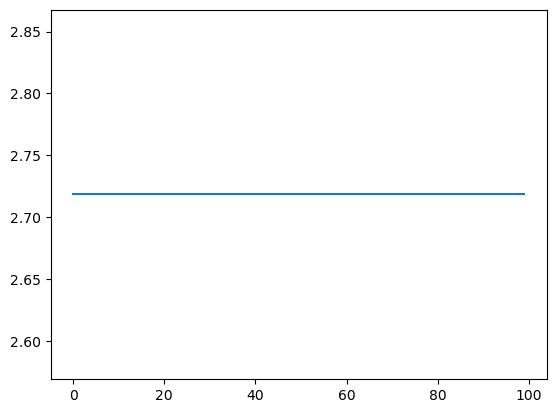

In [8]:
import matplotlib.pyplot as plt
plt.plot(loss)